# Trabajo pr√°ctico integrador - Visi√≥n por Computadoras II
## Carrera de Especializaci√≥n en Inteligencia Artificial - Cohorte 17
### Autores:
* Pi√±ero, Juan Cruz 
* Lloveras, Alejandro
* M√©ndez, Diego Mart√≠n

**Objetivo del trabajo**

Utilizar modelos de *Computer Vision* para clasificar enfermedades de plantas (38 clases).

## Inicializaci√≥n

In [ ]:
# Importaci√≥n de librer√≠as
# Gesti√≥n de archivos y reporte
import os
import shutil
import logging
import yaml

# Manipulaci√≥n y an√°lisis de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Procesamiento de im√°genes
from PIL import Image

# Machine Learning
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

### Carga de datos almacenados

In [3]:
# Cargamos el dataframe desde el .CSV y definimos 'id' como √≠ndice
try:
    df = pd.read_csv('dataframe.csv').set_index('id')
except FileNotFoundError:
    print(f"Error: El archivo 'dataframe.csv' no se encontr√≥ en la ubicaci√≥n actual: {os.getcwd()}")
    print("Se crear√° nuevamente al correr las celdas de 'Importaci√≥n de im√°genes'.")
    df = None
except Exception as e:
    print(f"Ocurri√≥ un error al leer el archivo CSV: {e}")
    df = None

In [ ]:
# Cargar variables desde el archivo YAML
try:
    # Verificar si el archivo YAML existe
    yaml_filename = "constants.yaml"
    with open(yaml_filename, "r") as yaml_file:
        constants_data = yaml.safe_load(yaml_file)

    # Acceder a las variables
    ROOT_DIR = constants_data.get("ROOT_DIR")
    DATASET_PATH = constants_data.get("DATASET_PATH")
    SPLITTED_PATH = constants_data.get("SPLITTED_PATH")

    print(f"‚úÖ Se han cargado las variables de configuraci√≥n desde '{yaml_filename}'")
    print(f" - ROOT_DIR: {ROOT_DIR}")
    print(f" - DATASET_PATH: {DATASET_PATH}")
    print(f" - SPLITTED_PATH: {SPLITTED_PATH}")
except FileNotFoundError:
    print(f"Error: El archivo 'constants.yaml' no se encontr√≥ en la ubicaci√≥n actual: {os.getcwd()}")
    print("Se crear√° nuevamente al correr el notebook.")
    ROOT_DIR = None
    DATASET_PATH = None
    SPLITTED_PATH = None
except Exception as e:
    print(f"Ocurri√≥ un error al leer el archivo YAML: {e}")

‚úÖ Se han cargado las variables de configuraci√≥n desde 'constants.yaml'
 - ROOT_DIR: /Users/alejandrolloveras/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/versions/3/plantvillage dataset/color
 - DATASET_PATH: /Users/alejandrolloveras/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/versions/3
 - SPLITTED_PATH: /Users/alejandrolloveras/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/splitted/


In [5]:
# ELIMINACI√ìN DEL DATASET DESCARGADO EN LOCAL
"""
# Es necesario ejetcutar antes las celdas 'Funciones necesarias'

# Busca la carpeta ra√≠z del dataset en el directorio donde fue descargado
path_to_remove = find_path("abdallahalidev")

# Valida la operaci√≥n y elimina carpetas y subcarpetas
import shutil
if os.path.exists(path_to_remove):
    respuesta = input(f"¬øEst√°s seguro de que deseas eliminar la carpeta y todo su contenido? [Y/N] {path_to_remove} :").lower()
    if respuesta == 'y':
        try:
            shutil.rmtree(path_to_remove)
            print(f"Se elimin√≥ correctamente la carpeta y su contenido: {path_to_remove}")
        except OSError as e:
            print(f"Error al eliminar la carpeta {path_to_remove}: {e}")
    else:
        print(f"Operaci√≥n de eliminaci√≥n cancelada por el usuario para: {path_to_remove}")
else:
    print(f"La carpeta no existe: {path_to_remove}")
"""

'\n# Es necesario ejetcutar antes las celdas \'Funciones necesarias\'\n\n# Busca la carpeta ra√≠z del dataset en el directorio donde fue descargado\npath_to_remove = find_path("abdallahalidev")\n\n# Valida la operaci√≥n y elimina carpetas y subcarpetas\nimport shutil\nif os.path.exists(path_to_remove):\n    respuesta = input(f"¬øEst√°s seguro de que deseas eliminar la carpeta y todo su contenido? [Y/N] {path_to_remove} :").lower()\n    if respuesta == \'y\':\n        try:\n            shutil.rmtree(path_to_remove)\n            print(f"Se elimin√≥ correctamente la carpeta y su contenido: {path_to_remove}")\n        except OSError as e:\n            print(f"Error al eliminar la carpeta {path_to_remove}: {e}")\n    else:\n        print(f"Operaci√≥n de eliminaci√≥n cancelada por el usuario para: {path_to_remove}")\nelse:\n    print(f"La carpeta no existe: {path_to_remove}")\n'

### Funciones necesarias

In [6]:
import os, re

# Busca la carpeta ra√≠z del dataset en el directorio donde fue descargado
def find_path(folder):
    match = re.search(fr"^(.*?)/{folder}/", DATASET_PATH)
    if match:
        prefix = match.group(1)
        path = os.path.join(prefix, f"{folder}/")
        return path
    else:
        print(f'No se ha podido encontrar la carpeta "{folder}" en {DATASET_PATH}')
        return None

In [7]:
# Carga de imagenes en memoria y visualizaci√≥n
def load_image(data: pd.DataFrame, index: int, root: str=ROOT_DIR):
    """
    Carga una imagen PIL desde una fila espec√≠fica de un DataFrame.

    Args:
        dataframe (pandas.DataFrame): El DataFrame que contiene las rutas de las im√°genes.
        index (int): El √≠ndice de la fila en el DataFrame para cargar la imagen.
        root_dir (str): El directorio ra√≠z donde se encuentran las im√°genes.

    Returns:
        PIL.Image.Image: La imagen cargada como un objeto PIL.Image, o None si ocurre un error.
    """
    if index < 0 or index >= len(data):
        print("√çndice fuera de rango.")
        return None

    row = data.iloc[index]
    relative_path = row['image_path']
    filename = row['filename']
    full_path = os.path.join(root, relative_path, filename)

    try:
        img = Image.open(full_path)
        return img
    except FileNotFoundError:
        print(f"Archivo no encontrado: {full_path}")
        return None
    except Exception as e:
        print(f"Error al cargar la imagen: {e}")
        return None

# Dataset

El dataset es 'PlantVillage' , obtenido de Kaggle con m√°s de 50 mil im√°genes RGB de hojas de cultivos sanas y enfermas, categorizadas en 38 clases diferentes. La primera versi√≥n del dataset fue disponibilizada por David. P. Hughes, Marcel Salathe y utilizado para desarrollar el proyecto 'PlantVillage' de la universidad de Penn State.

[**Link al Paper original**](https://arxiv.org/abs/1511.08060)

## Contenido del dataset



Dentro del dataset encontramos una jerarqu√≠a de carpetas que contienen imagenes. 
En el primer nivel encontramos tres carpetas que describen el tipo de imagen segun su preprocesamiento. Estas son:

- **color**: imagenes en color
- **grayscale**: mismas imagenes pero en escala de grises. En principio es desconocido el algoritmo utilizado.
    - apriori podriamos decir que la escala de grises no es ideal para detectar anomal√≠as en cultivos, ya que muchas enfermedades se manifiestan con una diferencia de color entre las partes afectadas y las partes no afectadas.   
- **segmented**: mismas imagenes pero despues de aplicar alg√∫n algoritmo de segmentaci√≥n. En principio es desconocido el algoritmo utilizado.
    - Haciendo una inspecci√≥n inicial podemos ver que no todas las segmentaciones son de buena calidad, por lo que apriori optar√≠amos por usar las im√°genes en color, haciendo algun preprocesamiento de las mismas por nuestra cuenta si fuera necesario.


Dentro de cada una de las tres carpetas que describen el preoposesamiento (color,grayscale,segmented) encontramos 38 carpetas, cada una con sus respectivas imagenes. Los nombres de las carpetas indican tanto la especie como la enfermedad o bien la palabra 'healthy' como indicador de que la imagen es de una planta sana . Por ejemplo, la carpeta "Apple___Apple_scab" contiene imagenes de hojas de manzana con 'Sarna del manzano'.

Como se puede ver en la descripci√≥n disponible en kaggle, el n√∫mero de imagenes dentro de cada clase var√≠a entre 152 y 5507 segun la especie y la enfermedad.

En el an√°lisis exploratorio obtenemos una tabla resumen con las especies y las enfermedades presentes en el dataset, as√≠ como la cardinalidad de cada conjunto.


### Tama√±o de las imagenes
Las im√°genes se encuentran normalizadas a un tama√±o de 256x256 pixeles.

[**Link al Dataset**](https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset)

#### Descarga de dataset de Kaggle

In [ ]:
import kagglehub

# Download latest version
DATASET_PATH = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

print("Path to dataset files:", DATASET_PATH)

/opt/anaconda3/envs/cv-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/alejandrolloveras/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/versions/3


Decidimos en principio trabajar con el dataset con im√°genes a color por ser el que contiene mayor informaci√≥n.

In [ ]:
# Ruta de acceso al dataset
ROOT_DIR = f'{DATASET_PATH}/plantvillage dataset/color'

## Descripci√≥n del problema


El objetivo es construir un modelo que permita diagnosticar las enfermedades mediante una foto de una hoja de una planta. Por lo tanto podemos diagramarlo como un problema de clasificaci√≥n. Donde las clases son las enfermedades, en conjunto con la especie de la planta. En otras palabras , las clases podr√≠an ser los nombres de las carpetas que contienen las imagenes.

### Estado del arte

La aplicaci√≥n de deep learning en este problema ha permitido grandes avances en los resultados obtenidos . Con los modelos del estado del arte se alcanzan resultados de mas de 95% de accuracy en clasificaci√≥n y niveles de precisi√≥n de m√°s del 90% en problemas de detecci√≥n y segmentaci√≥n de plagas y enfermedades en plantas / cultivos.

### Modelo a implementar como soluci√≥n

La cantidad de im√°genes en cada directorio nos permite predecir que , al intentar resolver la clasificaci√≥n, tendremos un problema de desbalance de clases. Por lo tanto ser√° importante tomar esto en cuenta a la hora de elegir la m√©trica a utilizar en el entrenamiento del modelo.

La exactitud del modelo as√≠ planteado estar√° l√≥gicamente limitada a las especies y enfermedades tratadas. Se podr√≠a tambien plantear un modelo donde se intente clasificar entre 'enferma' o 'sana' para intentar generalizar a otras especies o enfermedades, aunque esa generalizaci√≥n ser√≠a tambi√©n muy limitada dada la diversidad de especies que existen en el mundo real. Dicho problema en principio no lo contemplaremos en este trabajo. S√≥lo nos vamos a limitar a clasificar entre las 38 clases presentes en el dataset.

Una forma de incorporar al modelo m√°s complejidad e intentar abarcar otras especies podr√≠a ser utilizando Transfer Learning con un modelo pre-entrenado. Fine-tuneandolo para √©ste dataset. O bien utilizando t√©cnicas / arquitecturas de Few Shot Learning. 

### Etapa de preprocesamiento

El hecho de que el dataset ya cuente con directorios donde se facilitan los datos preprocesados, nos da un indicio de que esa etapa es muy importante para el problema que se quiere resolver.

Ser√° necesaria una etapa de preprocesamiento donde podamos aplicar alg√∫na transformaci√≥n de las imagenes para mejorar su calidad y poder obtener un mejor resultado en el entrenamiento. Dichas transformaciones podr√≠an consistir tanto en el resize como en transformaciones de espacio de color, segmentaciones, etc. 
A modo de referencia podemos mencionar un art√≠culo que explora el estado del arte en el tema de detecci√≥n de enfermedades en plantas con Computer Vision:

[_¬´Trends in Machine and Deep Learning Techniques for Plant Disease Identification: A Systematic Review¬ª_](
https://www.researchgate.net/profile/Juvenal-Rodriguez/publication/386275339_Trends_in_Machine_and_Deep_Learning_Techniques_for_Plant_Disease_Identification_A_Systematic_Review/links/674b1535f309a268c0193cd3/Trends-in-Machine-and-Deep-Learning-Techniques-for-Plant-Disease-Identification-A-Systematic-Review.pdf)

Seg√∫n este art√≠culo se destacan los siguientes items clave en el preprocesamiento de las imagenes:
- Resizing y cropping. La arquitectura a utilizar puede llegar a requerir un tama√±o determinado de la imagen de entrada.
- Normalizaci√≥n de las imagenes. Podria ser necesario llevar los valores de los pixeles a un rango normalizado [0,1]. Esto suele mitigar los efectos de variaciones en brillo y contraste.
- Reducci√≥n de ruido.
- Data augmentation: este proceso es clave cuando se cuenta con datasets de tama√±o o dispoinibilidad limitada. Se pueden aplicar operaciones variadas a las imagenes para aumentar la cantidad de datos y mejorar la generalizabilidad del modelo. Incluso se podr√≠a aplicar una GAN para generar imagenes sinteticas.
- Transformaciones de espacio de color: podria ser a escala de grises, HSV, etc.


## Importaci√≥n de im√°genes

In [ ]:
# CONFIGURACI√ìN INICIAL:
# Separador usado en los nombres de las subcarpetas
SEPARATOR = '___' # Separa entre 'group' y 'class'

# Extensiones de archivo de imagen a considerar (en min√∫sculas)
IMAGE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp'}

# Configuraci√≥n b√°sica de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [ ]:
def process_image_directory(root_dir, separator='___', valid_extensions=None):
    """
    Recorre un directorio ra√≠z, extrae rutas de im√°genes y metadatos de subcarpetas.

    Args:
        root_dir (str): La ruta al directorio ra√≠z que contiene las subcarpetas de clases.
        separator (str): El separador utilizado en los nombres de las subcarpetas
                         para dividir 'group' y 'class'.
        valid_extensions (set, optional): Un conjunto de extensiones de archivo (en min√∫sculas,
                                          incluyendo el punto) a considerar como im√°genes.
                                          Si es None, se usar√° un conjunto predeterminado.

    Returns:
        pandas.DataFrame: Un DataFrame con las columnas 'image_path', 'filename', 'group', 'class'.
                          Retorna un DataFrame vac√≠o si el directorio ra√≠z no existe o
                          no se encuentran im√°genes v√°lidas.
    """
    if valid_extensions is None:
        valid_extensions = IMAGE_EXTENSIONS # Verifica que sean archivos de imagen

    data = []
    output_columns = ['image_path', 'filename', 'class', 'group', 'tag'] # Define la estructura para el Dataframe

    if not os.path.isdir(root_dir):
        logging.error(f"El directorio ra√≠z especificado no existe: {root_dir}")
        return pd.DataFrame(data, columns=output_columns) # Asegura que exista el directorio

    logging.info(f"Comenzando el procesamiento del directorio: {root_dir}")

    # Exploraci√≥n de cada sucarpeta
    for entry in os.scandir(root_dir):
        if entry.is_dir():
            subdir_name = entry.name
            subdir_path = entry.path
            logging.info(f"Procesando subdirectorio: {subdir_name}")

            if separator in subdir_name:
                try:
                    group_name, tag = subdir_name.split(separator, 1)
                except ValueError:
                    logging.warning(f"No se pudo dividir el nombre '{subdir_name}' usando '{separator}'. Saltando directorio.")
                    continue

                for sub_entry in os.scandir(subdir_path):
                    if sub_entry.is_file():
                        file_name = sub_entry.name
                        file_path = sub_entry.path

                        _, extension = os.path.splitext(file_name)
                        if extension.lower() in valid_extensions:
                            relative_path = os.path.relpath(os.path.dirname(file_path), root_dir) # Carpeta d√≥nde encontrar a imagen
                            
                            # Almacena toda la informaci√≥n
                            data.append({
                                'image_path': f"{relative_path}/",
                                'filename': file_name,
                                'class': relative_path,
                                'group': group_name,
                                'tag': tag
                            })
                        else:
                            logging.debug(f"Archivo omitido (no es imagen v√°lida): {file_path}")
            else:
                logging.warning(f"El nombre del subdirectorio '{subdir_name}' no contiene el separador '{separator}'. Saltando.")

    if not data:
        logging.warning("No se encontraron im√°genes v√°lidas en la estructura de directorios especificada.")

    # Construye el DataFrame
    df = pd.DataFrame(data, columns=output_columns)
    logging.info(f"Proceso completado. Se encontraron {len(df)} im√°genes.")
    return df

In [ ]:
# Descomentar en caso de querer generarlo nuevamente el Dataframe
# del df

In [169]:
# Verificaci√≥n de importaci√≥n de Dataframe del CSV
build_df = False # inicializa el estado

try:
    if df is None:
        # No se ha podido importar el CSV
        build_df = True
    else:
        # El Dataframe ya ha sido cargado en memoria
        build_df = False
except NameError:
    # Cuando la variable 'df' a√∫n no ha sido definida
    build_df = True

In [ ]:
if build_df:
    print("El Dataframe a√∫n no ha sido creado, se procede a su construcci√≥n:")
    df = process_image_directory(ROOT_DIR)
else:
    print("El Dataframe ya ha sido importado, por lo que por eficiencia no se ejecutar√° nuevamente.\nEn caso de querer generarlo nuevamente descomentar las celdas anteriores y ejecutar nuevamente.")

2025-04-05 20:38:43,505 - INFO - Comenzando el procesamiento del directorio: /Users/alejandrolloveras/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/versions/3/plantvillage dataset/color
2025-04-05 20:38:43,507 - INFO - Procesando subdirectorio: Strawberry___healthy
2025-04-05 20:38:43,526 - INFO - Procesando subdirectorio: Grape___Black_rot
2025-04-05 20:38:43,554 - INFO - Procesando subdirectorio: Potato___Early_blight
2025-04-05 20:38:43,572 - INFO - Procesando subdirectorio: Blueberry___healthy
2025-04-05 20:38:43,598 - INFO - Procesando subdirectorio: Corn_(maize)___healthy
2025-04-05 20:38:43,619 - INFO - Procesando subdirectorio: Tomato___Target_Spot
2025-04-05 20:38:43,648 - INFO - Procesando subdirectorio: Peach___healthy
2025-04-05 20:38:43,654 - INFO - Procesando subdirectorio: Potato___Late_blight
2025-04-05 20:38:43,690 - INFO - Procesando subdirectorio: Tomato___Late_blight
2025-04-05 20:38:43,737 - INFO - Procesando subdirectorio: Tomato___Tomato_mosaic_vi

In [63]:
df.sample(5)

image_path  \
32676  Tomato___Tomato_Yellow_Leaf_Curl_Virus/   
46177                       Apple___Black_rot/   
11065                  Pepper,_bell___healthy/   
28529                        Tomato___healthy/   
44581                 Squash___Powdery_mildew/   

                                                filename  \
32676  1cd0ab0b-f4cf-4f2f-960a-455de4cd4c1e___YLCV_GC...   
46177  50755673-3ea3-4e06-acbb-703413571a91___JR_FrgE...   
11065  a8d0f75a-6f10-44db-b6c4-72f19646167d___JR_HL 5...   
28529  8f009cfa-d6f0-4e8b-8950-71638f04d2c1___RS_HL 0...   
44581  f7ed022b-2f5a-475d-ad90-bb6d162bbe3f___MD_Powd...   

                                        class         group  \
32676  Tomato___Tomato_Yellow_Leaf_Curl_Virus        Tomato   
46177                       Apple___Black_rot         Apple   
11065                  Pepper,_bell___healthy  Pepper,_bell   
28529                        Tomato___healthy        Tomato   
44581                 Squash___Powdery_mildew        Squash   

                                 tag  
32676  Tomato_Yellow_Leaf_Curl_Virus  
46177                      Black_rot  
11065                        healthy  
28529                        healthy  
44581                 Powdery_mildew

In [84]:
# Mueve el √≠ndice a una columna 'id' para poder tener un control de los datos durante el proceso de ETL
df = df.reset_index(names='id')

# Define la columna 'id' como index
df = df.set_index('id')

df.sample(5)

image_path  \
id                                                 
11480                    Pepper,_bell___healthy/   
50958                         Soybean___healthy/   
14769  Orange___Haunglongbing_(Citrus_greening)/   
25345               Corn_(maize)___Common_rust_/   
30342    Tomato___Tomato_Yellow_Leaf_Curl_Virus/   

                                                filename  \
id                                                         
11480  c0466e8b-d9cd-4bad-83c0-e8813b17788c___JR_HL 8...   
50958  d6b09d1b-49c8-46b8-b3c0-1c07d0b8e01f___RS_HL 3...   
14769  331ade5c-7616-4b52-97a2-39908eb8ee29___CREC_HL...   
25345                                   RS_Rust 1815.JPG   
30342  b31c5bf6-8fbe-4346-a2d4-c4eb1c3a2435___YLCV_NR...   

                                          class         group  \
id                                                              
11480                    Pepper,_bell___healthy  Pepper,_bell   
50958                         Soybean___healthy       Soybean   
14769  Orange___Haunglongbing_(Citrus_greening)        Orange   
25345               Corn_(maize)___Common_rust_  Corn_(maize)   
30342    Tomato___Tomato_Yellow_Leaf_Curl_Virus        Tomato   

                                   tag  
id                                      
11480                          healthy  
50958                          healthy  
14769  Haunglongbing_(Citrus_greening)  
25345                     Common_rust_  
30342    Tomato_Yellow_Leaf_Curl_Virus

In [85]:
# Guardamos el dataframe como .CSV para evitar realizar este proceso nuevamente
df.to_csv('dataframe.csv')

# An√°lisis exploratorio (EDA)

## Informaci√≥n general

In [ ]:
# Verificamos la importaci√≥n
df.sample(5)

image_path  \
id                                                 
16299  Orange___Haunglongbing_(Citrus_greening)/   
6777                            Peach___healthy/   
6449                       Tomato___Target_Spot/   
40489                    Peach___Bacterial_spot/   
12297  Orange___Haunglongbing_(Citrus_greening)/   

                                                filename  \
id                                                         
16299  c3761f85-eb13-446a-a673-19993d0a73dc___CREC_HL...   
6777   04c14871-257f-4067-80f7-ecc5e50f42a4___Rutg._H...   
6449   01e0b8b1-e713-4c6d-973b-f7636280c58a___Com.G_T...   
40489  82d203aa-eb50-4e38-b64b-0976fbcfb474___Rut._Ba...   
12297  2063fc79-fd1b-4669-8f0b-aeefb1a433cb___UF.Citr...   

                                          class   group  \
id                                                        
16299  Orange___Haunglongbing_(Citrus_greening)  Orange   
6777                            Peach___healthy   Peach   
6449                       Tomato___Target_Spot  Tomato   
40489                    Peach___Bacterial_spot   Peach   
12297  Orange___Haunglongbing_(Citrus_greening)  Orange   

                                   tag  
id                                      
16299  Haunglongbing_(Citrus_greening)  
6777                           healthy  
6449                       Target_Spot  
40489                   Bacterial_spot  
12297  Haunglongbing_(Citrus_greening)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54305 entries, 0 to 54304
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  54305 non-null  object
 1   filename    54305 non-null  object
 2   class       54305 non-null  object
 3   group       54305 non-null  object
 4   tag         54305 non-null  object
dtypes: object(5)
memory usage: 2.5+ MB


Verificamos que no hay valores nulos en las tiquetas, carpetas vac√≠as, ni errores en el procesamiento del dataset.

In [ ]:
df.describe()

image_path  \
count                                       54305   
unique                                         38   
top     Orange___Haunglongbing_(Citrus_greening)/   
freq                                         5507   

                                                 filename  \
count                                               54305   
unique                                              54305   
top     c7f4b7b2-b13c-476e-a936-c91ce39749a3___RS_HL 6...   
freq                                                    1   

                                           class   group      tag  
count                                      54305   54305    54305  
unique                                        38      14       21  
top     Orange___Haunglongbing_(Citrus_greening)  Tomato  healthy  
freq                                        5507   18160    15084

## Visualizaci√≥n de im√°genes

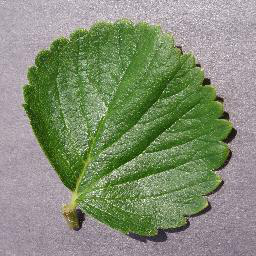

In [8]:
# Permite visualizar una imagen espec√≠fica (con iloc)
id = 0 # Indice de la imagen a cargar
image = load_image(data=df, index=id, root=ROOT_DIR)

#image.show() #popup option
image

Visualizando 10 im√°genes aleatorias:
Imagen #1 (√çndice: 51482):


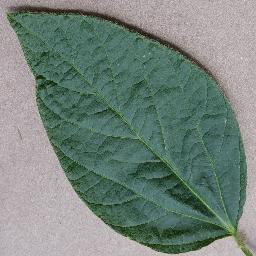

Imagen #2 (√çndice: 36574):


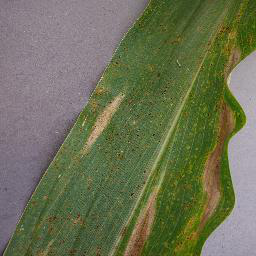

Imagen #3 (√çndice: 11431):


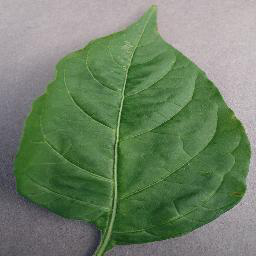

Imagen #4 (√çndice: 2653):


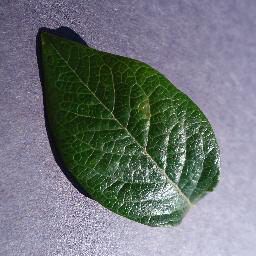

Imagen #5 (√çndice: 19158):


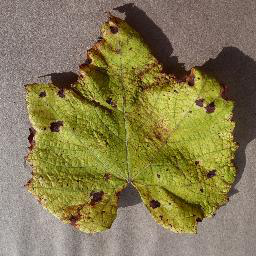

Imagen #6 (√çndice: 42733):


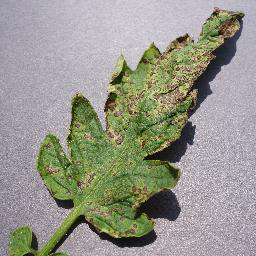

Imagen #7 (√çndice: 8820):


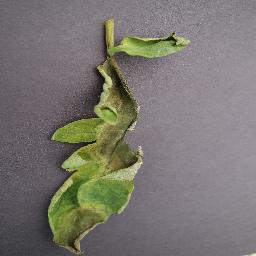

Imagen #8 (√çndice: 12377):


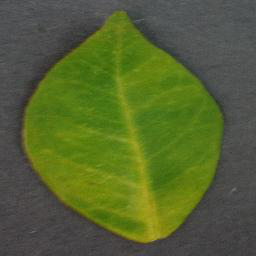

Imagen #9 (√çndice: 48358):


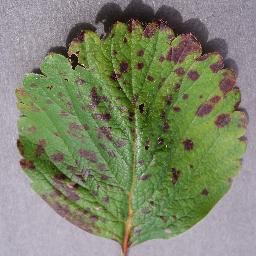

Imagen #10 (√çndice: 37101):


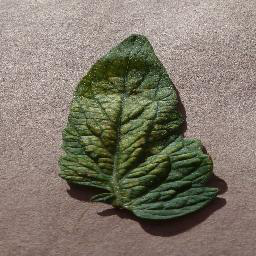

In [9]:
import random

# Obtener 10 √≠ndices aleatorios del DataFrame
num_to_display = 10
random_indices = random.sample(range(len(df)), num_to_display)

print(f"Visualizando {num_to_display} im√°genes aleatorias:")
for i, index in enumerate(random_indices):
    try:
        image = load_image(data=df, index=index, root=ROOT_DIR)
        print(f"Imagen #{i+1} (√çndice: {index}):")
        display(image) # Muestra la imagen directamente en entornos como Jupyter Notebook
    except FileNotFoundError:
        print(f"Error: No se encontr√≥ la imagen en la ruta: {os.path.join(ROOT_DIR, df.loc[index, 'relative_path'])}")
    except Exception as e:
        print(f"Error al cargar la imagen en el √≠ndice {index}: {e}")

## Tama√±o de las im√°genes

In [ ]:
sizes = []
for index in range (0,df.shape[0]):
    
    image = load_image(data=df, index=index, root=ROOT_DIR)
    sizes.append(image.size)

In [ ]:
set(sizes)

{(256, 256)}

## Distribuci√≥n entre clases

In [102]:
print("Conteo por grupo:")
print(df['group'].value_counts())

Conteo por grupo:
group
Tomato                     18160
Orange                      5507
Soybean                     5090
Grape                       4062
Corn_(maize)                3852
Apple                       3171
Peach                       2657
Pepper,_bell                2475
Potato                      2152
Cherry_(including_sour)     1906
Squash                      1835
Strawberry                  1565
Blueberry                   1502
Raspberry                    371
Name: count, dtype: int64


In [103]:
print("Conteo por etiqueta:")
print(df['tag'].value_counts())

Conteo por etiqueta:
tag
healthy                                15084
Haunglongbing_(Citrus_greening)         5507
Bacterial_spot                          5421
Tomato_Yellow_Leaf_Curl_Virus           5357
Late_blight                             2909
                                       ...  
Leaf_Mold                                952
Apple_scab                               630
Cercospora_leaf_spot Gray_leaf_spot      513
Tomato_mosaic_virus                      373
Cedar_apple_rust                         275
Name: count, Length: 21, dtype: int64


In [104]:
df[df['group'] == 'Raspberry']['tag'].value_counts()

tag
healthy    371
Name: count, dtype: int64

Como puede verse, todos los datos pertenecientes al grupo `Raspberry` tienen la etiqueta `helathy`.

Esto indica que no se cuenta con datos de enfermedades para esta clase.

# Dataset split

#### Funciones

In [8]:
from sklearn.model_selection import train_test_split

def split_data(df,
               target_column='class',
               test_size=0.20,
               validation_size=0.0, # Por defecto no define un conjunto de validaci√≥n
               random_state=42,     # Semilla para reproducibilidad
               split_column_name='split'):
    """
    A√±ade una columna al DataFrame indicando la divisi√≥n (train/test/validation).

    Realiza una divisi√≥n estratificada para mantener el balance de clases.

    Args:
        df (pd.DataFrame): DataFrame de entrada con al menos la columna 'target_column'.
        target_column (str): Nombre de la columna que contiene las etiquetas de clase
                             para la estratificaci√≥n (ej: 'class').
        test_size (float): Proporci√≥n del dataset a incluir en el conjunto de test (ej: 0.20).
        validation_size (float): Proporci√≥n del dataset a incluir en el conjunto de validaci√≥n.
                                 La proporci√≥n de entrenamiento ser√° 1.0 - test_size - validation_size.
                                 Si es 0.0, solo se crear√°n conjuntos de train y test.
        random_state (int): Semilla para el generador de n√∫meros aleatorios para asegurar
                            divisiones reproducibles.
        split_column_name (str): Nombre de la nueva columna que contendr√° las etiquetas
                                 'train', 'test' o 'validation'.

    Returns:
        pd.DataFrame: El DataFrame original con la nueva columna 'split_column_name'.

    Raises:
        ValueError: Si test_size + validation_size >= 1.0, o si target_column no existe.
        ImportError: Si scikit-learn no est√° instalado.
    """
    if target_column not in df.columns:
        raise ValueError(f"La columna objetivo '{target_column}' no se encuentra en el DataFrame.")

    if not isinstance(test_size, float) or not (0.0 <= test_size < 1.0):
         raise ValueError("test_size debe ser un float entre 0.0 y 1.0.")

    if not isinstance(validation_size, float) or not (0.0 <= validation_size < 1.0):
         raise ValueError("validation_size debe ser un float entre 0.0 y 1.0.")

    if test_size + validation_size >= 1.0:
        raise ValueError("La suma de test_size y validation_size debe ser menor que 1.0.")

    # Crear la nueva columna inicializada (opcional, pero ayuda a la claridad)
    df[split_column_name] = 'unassigned'

    # Extraer etiquetas para estratificaci√≥n
    labels = df[target_column]
    indices = df.index # Usaremos los √≠ndices para la divisi√≥n

    # --- L√≥gica de Divisi√≥n ---

    # Caso 1: Divisi√≥n en Train / Test (sin Validaci√≥n)
    if validation_size == 0.0:
        train_indices, test_indices = train_test_split(
            indices,
            test_size=test_size,
            random_state=random_state,
            stratify=labels # Permite mantener el balance de clases
        )
        df.loc[train_indices, split_column_name] = 'train'
        df.loc[test_indices, split_column_name] = 'test'
        logging.info(f"Divisi√≥n completada: Train ({1-test_size:.1%}), Test ({test_size:.1%}). Estratificada por '{target_column}'.")

    # Caso 2: Divisi√≥n en Train / Test / Validation
    else:
        # Paso 1: Dividir en (Train + Validation) y Test
        remaining_indices, test_indices = train_test_split(
            indices,
            test_size=test_size, # Tama√±o final del conjunto de test
            random_state=random_state,
            stratify=labels
        )

        # Calcular el tama√±o relativo de validaci√≥n respecto al conjunto restante (Train + Validation)
        # Ejemplo: test=0.2, val=0.1 -> Total 0.3. Restante 0.7. val_rel = 0.1 / 0.7 = 0.142...
        # train_test_split tomar√° el 14.2% del 70% restante, lo que equivale al 10% del total original.
        relative_val_size = validation_size / (1.0 - test_size)

        # Obtener las etiquetas correspondientes SOLO al conjunto restante para la segunda estratificaci√≥n
        remaining_labels = df.loc[remaining_indices, target_column]

        # Paso 2: Dividir el conjunto restante en Train y Validation
        train_indices, validation_indices = train_test_split(
            remaining_indices, # Dividir solo los √≠ndices restantes
            test_size=relative_val_size, # Tama√±o relativo calculado
            random_state=random_state,   # Usar la misma semilla para consistencia
            stratify=remaining_labels    # Estratificar usando las etiquetas restantes
        )

        # Asignar etiquetas de divisi√≥n al DataFrame original
        df.loc[train_indices, split_column_name] = 'train'
        df.loc[validation_indices, split_column_name] = 'valid'
        df.loc[test_indices, split_column_name] = 'test'

        train_actual_prop = len(train_indices) / len(df)
        val_actual_prop = len(validation_indices) / len(df)
        test_actual_prop = len(test_indices) / len(df)
        logging.info(f"Divisi√≥n completada: Train ({train_actual_prop:.1%}), Validation ({val_actual_prop:.1%}), Test ({test_actual_prop:.1%}). Estratificada por '{target_column}'.")

    return df

In [ ]:
def dataset_already_exists(path_to_check: str) -> bool | None:
    """
    Verifica si el directorio especificado existe y est√° vac√≠o.

    Args:
        path_to_check (str): Ruta del directorio a verificar.

    Returns:
        bool: True si el directorio existe y est√° vac√≠o, False en caso contrario.
    """
    if not os.path.exists(path_to_check):
        # El directorio no existe -> Crea el directorio
        #print(f"‚òëÔ∏è El directorio no existe, a√∫n no ha sido creado:\n > {path_to_check}") # Debugging
        return False # No realiza ninguna acci√≥n
    else:
        # Verificar si el directorio est√° vac√≠o
        try:
            # Explora el contenido del directorio
            content = os.listdir(path_to_check)
            #print(content) # Debugging

            # Si el directorio est√° vac√≠o, se puede eliminar directamente
            #       -> Elimina sin confirmaci√≥n
            if not content:
                os.rmdir(path_to_check) # Elimina el directorio vac√≠o
                print(f"‚òëÔ∏è El directorio estaba vac√≠o y se ha eliminado de forma autom√°tica:\n > {path_to_check}\n")
                return False
            
            # Si el directorio contiene s√≥lo archivos ocultos (de sistema)
            #       -> Elimina sin confirmaci√≥n
            elif all([file.startswith('.') for file in content]):
                shutil.rmtree(path_to_check) # Elimina el directorio y su contenido
                print(f"‚òëÔ∏è El directorio s√≥lo conten√≠a archivos ocutlos, por lo que se ha eliminado de forma autom√°tica:\n > {path_to_check}\n")
                return False

            # Si hay archivos visibles en el directorio (dataset ya existe)
            #       -> Solicita permiso para eliminarlos
            else:
                # Input de confirmaci√≥n del usuario
                confirmacion = input(f"‚ö†Ô∏è El directorio especificado ya existe y contiene archivos. ¬øDeseas eliminar todo su contenido y el directorio en s√≠? [Y/N]: '{path_to_check}'").strip().lower()
                # Verifica la respuesta del usuario
                if confirmacion == 'y':
                    shutil.rmtree(path_to_check) # Elimina el directorio y su contenido
                    print(f"‚úÖ El directorio y su contenido han sido eliminados exitosamente:\n > {path_to_check}\n")
                    return False
                else:
                    print(f"‚õîÔ∏è La eliminaci√≥n del directorio ha sido denegada por el usuario:\n  > {path_to_check}")
                    return True
        
        except OSError as e:
            print(f"‚ùå Error al eliminar el directorio vac√≠o en {path_to_check}: {e}\n")
            return None
        except Exception as e:
            print(f"‚ÄºÔ∏è Ocurri√≥ un error inesperado al intentar eliminar el directorio vac√≠o en {path_to_check}: {e}\n")
            return None

In [ ]:
def create_ignore_function(df, train_label, filename_col='filename'):
    """
    Crea y devuelve la funci√≥n 'ignore_files' que tiene acceso al DataFrame
    y sabe qu√© archivos mantener.
    """
    # Crea un conjunto (set) con los nombres de archivo que S√ç queremos copiar (ej: split == 'train')
    # Usa este conjunto para hacer la b√∫squeda de forma mucho m√°s r√°pida
    files_to_keep = set(df[df['split'] == train_label][filename_col])
    #print(f"Archivos a mantener (split='{train_label}'): {files_to_keep}") # Debugging

    def ignore_files(current_dir, files_in_current_dir):
        """
        Funci√≥n que ser√° llamada por shutil.copytree.
        Decide qu√© archivos/directorios ignorar en el directorio actual.
        """
        ignore_list = []
        for item in files_in_current_dir:
            # Construye la ruta completa para verificar si es archivo o directorio
            full_path = os.path.join(current_dir, item)

            # Aplicar la l√≥gica de ignorar SOLO los ARCHIVOS de la lista
            if os.path.isfile(full_path):
                # Si el nombre del archivo NO est√° en el conjunto de archivos a mantener,
                # entonces lo agrega a la lista de ignorados.
                if item not in files_to_keep:
                    # print(f"Ignorando archivo: {item} (en {current_dir})") # Debugging
                    ignore_list.append(item)

        # print(f"Directorio: {current_dir}, Ignorando: {ignore_list}") # Debugging
        return ignore_list

    # Devuelve la funci√≥n 'ignore_files' configurada
    return ignore_files


## Divis√≥n de datos

In [ ]:
# Disivi√≥n del dataset
# (Ejemplo: 80% train, 20% test)
try:
        df_split = split_data(df.copy(), # Usar .copy() para no modificar el original directamente aqu√≠
                                target_column='class',
                                test_size=0.2,
                                random_state=42) # Usa la semilla que prefieras

except ValueError as e:
        print(f"\nError al dividir los datos: {e}")
except ImportError:
        print("\nError: La biblioteca scikit-learn no est√° instalada. Por favor, inst√°lala con 'pip install scikit-learn'")
except Exception as e:
        print(f"\nOcurri√≥ un error inesperado: {e}")


In [113]:
df_split.sample(5)

image_path  \
id                                                      
12418       Orange___Haunglongbing_(Citrus_greening)/   
3707                             Blueberry___healthy/   
36742  Tomato___Spider_mites Two-spotted_spider_mite/   
19954       Cherry_(including_sour)___Powdery_mildew/   
49302                              Soybean___healthy/   

                                                filename  \
id                                                         
12418  885a6772-0c95-4805-bc03-fe7a5b07c073___CREC_HL...   
3707   40f80efb-32a6-4805-9c01-ada369c6900b___RS_HL 5...   
36742  6eb5d1ea-faf3-4a41-8419-89158aef70a5___Com.G_S...   
19954  5cdf0423-83a1-42ec-97f0-4c91a6130cb4___FREC_Pw...   
49302  d5006066-4ff3-4264-860d-0773a2418039___RS_HL 3...   

                                               class                    group  \
id                                                                              
12418       Orange___Haunglongbing_(Citrus_greening)                   Orange   
3707                             Blueberry___healthy                Blueberry   
36742  Tomato___Spider_mites Two-spotted_spider_mite                   Tomato   
19954       Cherry_(including_sour)___Powdery_mildew  Cherry_(including_sour)   
49302                              Soybean___healthy                  Soybean   

                                        tag  split  
id                                                  
12418       Haunglongbing_(Citrus_greening)  train  
3707                                healthy   test  
36742  Spider_mites Two-spotted_spider_mite  train  
19954                        Powdery_mildew  train  
49302                               healthy   test

In [114]:
df_split['split'].value_counts()

split
train    43444
test     10861
Name: count, dtype: int64

In [115]:
# Guardamos el dataframe como .CSV para evitar realizar este proceso nuevamente
df_split.to_csv('dataframe_splitted.csv')

In [ ]:
print("\n--- Conteo de muestras por 'split' ---")
print(df_split['split'].value_counts(normalize=True)) # normalize=True muestra proporciones

print("\n--- Verificaci√≥n del Balance de Clases por 'split' ---")

# Comprobar si las proporciones de clases son similares en cada split
print(df_split.groupby('split')['class'].value_counts(normalize=True))


--- Conteo de muestras por 'split' ---
split
train    0.8
test     0.2
Name: proportion, dtype: float64

--- Verificaci√≥n del Balance de Clases por 'split' ---
split  class                                   
test   Orange___Haunglongbing_(Citrus_greening)    0.101464
       Tomato___Tomato_Yellow_Leaf_Curl_Virus      0.098610
       Soybean___healthy                           0.093730
       Peach___Bacterial_spot                      0.042353
       Tomato___Bacterial_spot                     0.039131
                                                     ...   
train  Tomato___Tomato_mosaic_virus                0.006859
       Raspberry___healthy                         0.006836
       Peach___healthy                             0.006629
       Apple___Cedar_apple_rust                    0.005064
       Potato___healthy                            0.002808
Name: proportion, Length: 76, dtype: float64


Se verifica que se conserva el balance original entre clases en el split de datos.

### Construcci√≥n de carpetas

In [11]:
# Cargamos el dataframe procesado desde .CSV
df_split = pd.read_csv('dataframe_splitted.csv').set_index('id')

In [9]:
df_split.sample()

image_path  \
id                                                 
19881  Cherry_(including_sour)___Powdery_mildew/   

                                                filename  \
id                                                         
19881  e79eda22-9c31-4e34-87e1-e1c9ae2d6449___FREC_Pw...   

                                          class                    group  \
id                                                                         
19881  Cherry_(including_sour)___Powdery_mildew  Cherry_(including_sour)   

                  tag split  
id                           
19881  Powdery_mildew  test

In [10]:
# Guarda directorio del dataset dividido
path = find_path("plantvillage-dataset")
SPLITTED_PATH = f"{path}splitted/" if path else None
SPLITTED_PATH

'/Users/alejandrolloveras/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/splitted/'

In [14]:
splits = df_split['split'].value_counts().index.tolist()
splits

['train', 'test']

In [18]:
verfication = True # Ejecuta el proceso de verificaci√≥n (punto 2)

print(f"Se inicia proceso de copiado del dataset‚Ä¶")
total_files = len(df_split) # Total de archivos del dataset
print(f" - Total de archivos en el dataset: {total_files}")

# Realiza el proceso de copiado de archivos para cada split
succeeded_process = True
for split in splits:
    # Crea las rutas de origen y destino
    # (Ejemplo: 'train', 'test', 'valid')
    print(f"\n\nIniciando proceso para '{split}' split ‚Ä¶")
    source_folder = f'{ROOT_DIR}/'
    destination_folder = f'{SPLITTED_PATH}{split}/'
    total_split = len(df_split[df_split['split'] == split]) # Total de archivos del split
    if dataset_already_exists(destination_folder): # Verifica si el directorio existe y est√° vac√≠o
        print("  ‚®Ø El directorio ya existe y contiene archivos, a petici√≥n del usuario se omite el proceso de copiado.")
        continue # Si el directorio ya existe, no se hace nada+
    else:
        print(f"üîÑ Procesando split '{split.upper()}' ({(total_split/total_files*100):.2f}):")
        print(f"  - Total de archivos a copiar: {total_split}")
    succeeded = False

    try:
        print(f"1. Creando estructura de subcarpetas:")
        # 1. Crea la funci√≥n para ignorar espec√≠fica para el split a procesar
        ignore_function = create_ignore_function(df_split, train_label=split, filename_col='filename')
        print(f"    ‚úî Funci√≥n de filtro creada para el split ")

        # 2. Con copytree copia todo el "√°rbol" de directorios (careptas y subcarpetas)
        # Fitrando con ignore_function todos aquellos archivos que no pertenecen al split deseado
        print(f"    ‚àû Copiando contenido del dataset (puede demorar hasta un minuto).")
        shutil.copytree(source_folder, destination_folder, ignore=ignore_function)
        print(f"    ‚úî Proceso de copiado del split finalizado.")

        if verfication:
            # Verifica qu√© se haya copiado adecuadamente (opcional pero √∫til)
            print(f"2. Se inicia proceso de verificaci√≥n‚Ä¶")
            copied_files = []
            for root, dirs, files_in_dest in os.walk(destination_folder):
                for name in files_in_dest:
                    copied_files.append(os.path.join(os.path.relpath(root, destination_folder), name).replace('\\', '/')) # Normalizar path
                    #print(f"  - {os.path.join(root, name)}") # Debuggin
            print(f"    ‚úî Se crearon un total de {len(os.listdir(destination_folder))} carpetas (para las clases).")
            print(f"    ‚úî Se copiaron un total de {len(copied_files)} archivos ({len(copied_files)/total_split*100:.2f}%)")
            # Agregar confirmaci√≥n de igualdad cantidad split == copiados
            if len(copied_files) == total_split:
                print(f"‚úÖ Se complet√≥ satisfactoriamente el subproceso de copiado para el split.\n")
                succeeded = True
            else:
                print(f" ‚ùå Error: No se pudo copiar correctamente el split '{split.upper()}'\n")
                succeeded = False
        else:
            succeeded = True # Si la verificaci√≥n est√° desactivada, se asume que el proceso fue exitoso

    except FileExistsError:
        print(f"Error: La carpeta de destino '{destination_folder}' ya existe.\n")
        pass
    except Exception as e:
        print(f"Ocurri√≥ un error inesperado: {e}\n")

    succeeded_process *= succeeded # Actualiza el estado del proceso
    # (S√≥lo es 'True' si todos los splits se copian correctamente)

if succeeded_process:
    print("\n\nüåü El proceso de copiado del dataset ha finalizado con √©xito.\n")
else:
    print("\n\nüö´ No se pudo completar satisfactoriamente el proceso de copiado del dataset.\nVerificar que se haya completado la eliminaci√≥n de las carpetas.\n")

Se inicia proceso de copiado del dataset‚Ä¶
 - Total de archivos en el dataset: 54305


Iniciando proceso para 'train' split ‚Ä¶
‚úÖ El directorio y su contenido han sido eliminados exitosamente:
 > /Users/alejandrolloveras/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/splitted/train/

üîÑ Procesando split 'TRAIN' (80.00):
  - Total de archivos a copiar: 43444
1. Creando estructura de subcarpetas:
    ‚úî Funci√≥n de filtro creada para el split 
    ‚àû Copiando contenido del dataset (puede demorar hasta un minuto).
    ‚úî Proceso de copiado del split finalizado.
2. Se inicia proceso de verificaci√≥n‚Ä¶
    ‚úî Se crearon un total de 38 carpetas (para las clases).
    ‚úî Se copiaron un total de 43444 archivos (100.00%)
‚úÖ Se complet√≥ satisfactoriamente el subproceso de copiado para el split.



Iniciando proceso para 'test' split ‚Ä¶
‚úÖ El directorio y su contenido han sido eliminados exitosamente:
 > /Users/alejandrolloveras/.cache/kagglehub/datasets/abdallahalid

In [28]:
import yaml

# Define tus constantes como un diccionario de Python
constants_data = {
    "ROOT_DIR": ROOT_DIR,
    "DATASET_PATH": DATASET_PATH,
    "SPLITTED_PATH": SPLITTED_PATH
}

# Especifica el nombre del archivo para tu archivo YAML
yaml_filename = "constants.yaml"

# Escribe el diccionario de Python en un archivo YAML
with open(yaml_filename, "w") as yaml_file:
    yaml.dump(constants_data, yaml_file, default_flow_style=False)

print(f"‚úÖ Se han almacenado las variables de configuraci√≥n en '{yaml_filename}'")

‚úÖ Se han almacenado las variables de configuraci√≥n en 'constants.yaml'


## Dataloader

In [12]:
splits = df_split['split'].value_counts().index.tolist()
splits

['train', 'test']

In [ ]:
# Data laoders setup
def load_from_directory(data_folder):
    """
    Carga un dataset de im√°genes desde un directorio espec√≠fico.

    Args:
        data_folder (str): Ruta al directorio que contiene las im√°genes.

    Returns:
        tf.data.Dataset: Dataset de TensorFlow con las im√°genes y etiquetas.
    """
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_folder,  # Ruta al directorio de datos
        labels="inferred",  # Las etiquetas se infieren autom√°ticamente desde los nombres de las carpetas
        label_mode="categorical",  # Las etiquetas se codifican como categor√≠as (one-hot encoding)
        class_names=None,  # Las clases se detectan autom√°ticamente
        color_mode="rgb",  # Las im√°genes se cargan en modo RGB
        batch_size=32,  # Tama√±o de lote para el entrenamiento
        image_size=(256, 256),  # Redimensiona las im√°genes a 128x128 p√≠xeles
        shuffle=True,  # Mezcla las im√°genes aleatoriamente
        seed=42,  # No se utiliza una semilla espec√≠fica para la aleatorizaci√≥n
        validation_split=None,  # No se realiza una divisi√≥n de validaci√≥n aqu√≠
        subset=None,  # No se especifica un subconjunto (train/validation)
        interpolation="bilinear",  # M√©todo de interpolaci√≥n para redimensionar las im√°genes
        follow_links=False,  # No sigue enlaces simb√≥licos
        crop_to_aspect_ratio=False  # No recorta las im√°genes para ajustar la relaci√≥n de aspecto
    )

    return dataset

In [73]:
# Carga el dataset de im√°genes desde el directorio especificado
train_images = ""; test_images = ""; valid_images = ""

print("Cargando datasets desde el directorio‚Ä¶\n")
for split in splits:
    data_folder = f'{SPLITTED_PATH}{split}/'
        
    # Carga el conjunto de datos desde el directorio especificado
    # Utiliza la funci√≥n de TensorFlow para crear un dataset de im√°genes
    match split:
        case 'train':
            print(f"Cargando dataset de entrenamiento desde:\n > {data_folder}")
            train_images = load_from_directory(data_folder) 
        case 'test':
            print(f"Cargando dataset de test desde:\n > {data_folder}")
            test_images = load_from_directory(data_folder) 
        case 'valid':               
            print(f"Cargando dataset de validaci√≥n desde:\n > {data_folder}")
            valid_images = load_from_directory(data_folder)
        case _: # En caso de no coincidir con ninguno de los splits
            print(f"‚ö†Ô∏è El split '{split}' no es reconocido. No se cargar√° ning√∫n dataset.")
            continue # Salta al siguiente split
    print(f"‚úÖ Dataset cargado exitosamente.\n")

Cargando datasets desde el directorio‚Ä¶

Cargando dataset de entrenamiento desde:
 > /Users/alejandrolloveras/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/splitted/train/
Found 43444 files belonging to 38 classes.
‚úÖ Dataset cargado exitosamente.

Cargando dataset de test desde:
 > /Users/alejandrolloveras/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/splitted/test/
Found 10861 files belonging to 38 classes.
‚úÖ Dataset cargado exitosamente.



Verificamos que los archivos se hayan cargado correctamente:

In [72]:
print("Resumen de los datasets cargados:")
print(f" - Total de im√°genes en el dataset de entrenamiento: {len(train_images)}")
print(f" - Total de im√°genes en el dataset de validaci√≥n: {len(valid_images)}")
print(f" - Total de im√°genes en el dataset de test: {len(test_images)}")
print(f"Total de im√°genes cargadas: {len(train_images) + len(test_images) + len(valid_images)}\n")

Resumen de los datasets cargados:
 - Total de im√°genes en el dataset de entrenamiento: 1358
 - Total de im√°genes en el dataset de validaci√≥n: 0
 - Total de im√°genes en el dataset de test: 340
Total de im√°genes cargadas: 1698



In [71]:

print(f"Clases detectadas:")
[print(" -",clase) for clase in train_images.class_names]
print(f"Total de clases: {len(train_images.class_names)}")

Clases detectadas:
 - Apple___Apple_scab
 - Apple___Black_rot
 - Apple___Cedar_apple_rust
 - Apple___healthy
 - Blueberry___healthy
 - Cherry_(including_sour)___Powdery_mildew
 - Cherry_(including_sour)___healthy
 - Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
 - Corn_(maize)___Common_rust_
 - Corn_(maize)___Northern_Leaf_Blight
 - Corn_(maize)___healthy
 - Grape___Black_rot
 - Grape___Esca_(Black_Measles)
 - Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
 - Grape___healthy
 - Orange___Haunglongbing_(Citrus_greening)
 - Peach___Bacterial_spot
 - Peach___healthy
 - Pepper,_bell___Bacterial_spot
 - Pepper,_bell___healthy
 - Potato___Early_blight
 - Potato___Late_blight
 - Potato___healthy
 - Raspberry___healthy
 - Soybean___healthy
 - Squash___Powdery_mildew
 - Strawberry___Leaf_scorch
 - Strawberry___healthy
 - Tomato___Bacterial_spot
 - Tomato___Early_blight
 - Tomato___Late_blight
 - Tomato___Leaf_Mold
 - Tomato___Septoria_leaf_spot
 - Tomato___Spider_mites Two-spotted_spider_mite
 

----

In [ ]:
history = model.fit(train_images,
                    validation_data=valid_images,
                    epochs=10)

# Development toolkit
Funciones para testing, se eliminar√°n del notebook definitivo.

In [67]:
import time
def delete_for_testing(sec):
    if os.path.isdir(SPLITTED_PATH):
        try:
            shutil.rmtree(SPLITTED_PATH)
            #print(f"‚úÖ El directorio y su contenido han sido eliminados exitosamente:\n > {SPLITTED_PATH}")
        except OSError as e:
            print(f"‚ùå Error al eliminar el directorio en {SPLITTED_PATH}: {e}")
    time.sleep(sec)

In [20]:
import time
from functools import wraps

def measure_execution_time(num_runs=100):
    """
    A decorator to measure the average execution time of a function over multiple runs.

    Args:
        num_runs (int): The number of times to execute the function. Defaults to 10.

    Returns:
        The wrapped function that will print the average execution time.
    """
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            total_time = 0
            count = 0
            for _ in range(num_runs):
                print(f"Starting run {count+1} ‚Ä¶")
                start_time = time.perf_counter()
                result = func(*args, **kwargs)
                end_time = time.perf_counter()
                total_time += (end_time - start_time)
                partial_time = total_time / (count+1)
                print(f"- Run {count+1} ended | Avg time {partial_time} sec")
                print(f"  Expected to finish {round((num_runs-(count+1))*partial_time/60):.2f} min")
                count += 1
            average_time = total_time / num_runs
            print(f"Function '{func.__name__}' executed {num_runs} times.")
            print(f"Average execution time: {average_time:.6f} seconds")
            return result
        return wrapper
    return decorator